# Neural Networks

<a id='toc'></a> 

# TOC

1. [Individual Neurons](#Neurons)
2. [Forward Propogation](#fprop)
3. [Back Propogation](#backprop)


Deep learning is a subfield of machine learning which involves training neural networks to solve complex problems which the algorithms we have introduced in earlier phases cannot handle.  Deep learning has made progress solving many important things, including:

- image classification
- speech recognition
- handwriting transcription
- translation
- text-to-speech conversion
- Digital assistants such as Alexa
- autonomous driving
- ad targeting, as used by Google, Baidu, and Bing
- natural-language questions

[source](https://livebook.manning.com/book/deep-learning-with-python/chapter-1/59)

The "deep" in deep learning refers to neural networks which had multiple layers of neurons.  The more layers, the deeper the network. Each successive layer can be thought as finding more complex relationships within our data.

<a id="Neurons"></a>

# Individual Neurons

## Brief History
 

Neural networks have been around for a while. They are over 70 years old, dating back to  their proposal in 1944 by Warren McCullough and Walter Pitts in a paper called "A Logical Calculus of the Ideas Immanent in Nervous Activity," a copy of which you can find with a quick Google search.

These first proposed neural nets were based on analogs in biological neurons such as all-or-none firing and groups of neurons sending signals to connected neurons.   The individual neurons were relatively simple. Each neuron summed signal inputs together and judged whether a certain threshold were met. If the threshold were met,the neuron fired.  If you are familiar with the basics of biological neurons, this schema mirrors that of the firing of an action potential. These first proposed neural nets had no specific training mechanisms.

The "Perceptron" the first trainable neural network, was proposed by Frank Rosenblatt in 1957. It consisted of a single layer with adjustable weights in the middle of input and output layers.  We can think of a perceptron as a single neuron in our network.

![peceptron](img/nn-diagram.png)

The perceptron in its original form took binary inputs and predicted a binary outcome.  Similar to how a biological neuron's action potential fires if a certain electrical input signal were strong enough, it proposed an activation which converted the input into an all-or-none output.  The activation function looked like so:

\begin{eqnarray}
  \mbox{output} & = & \left\{ \begin{array}{ll}
      0 & \mbox{if } \sum_j w_j x_j \leq \mbox{ threshold} \\
      1 & \mbox{if } \sum_j w_j x_j > \mbox{ threshold}
      \end{array} \right.
\end{eqnarray}

which can be rewritten as:
    
\begin{eqnarray}
  \mbox{output} = \left\{ 
    \begin{array}{ll} 
      0 & \mbox{if } w\cdot x + b \leq 0 \\
      1 & \mbox{if } w\cdot x + b > 0
    \end{array}
  \right.
\end{eqnarray}

The problem with the above perceptron is that it does not allow for an effective method of learning. In order to build effective learning algorithms, we require the ability to tune the output of our neuron with slight changes to our weights and biases.

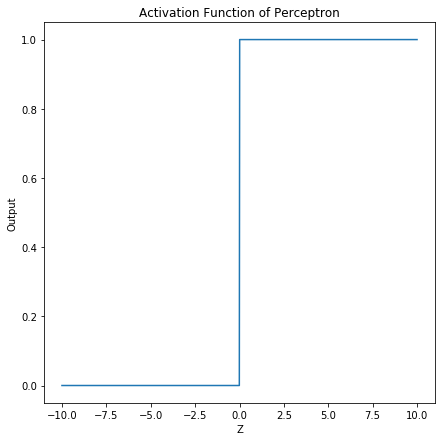

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

# Example result of a perceptron's summation
z = np.linspace(-10,10,1000)

# Example output of a perceptron's activation function
y = [1 if output > 0 else 0  for output in z ]

fig, ax = plt.subplots(figsize=(7,7))
sns.lineplot(x=z,y=y, ax=ax)
ax.set_title('Activation Function of Perceptron')
ax.set_xlabel('Z')
ax.set_ylabel('Output');

Thinking about the activation function above, imaging making a small change to a beta coefficient.  The small change results in a small change in z, but because the slope of the activation function is zero in all places except when z = 0, we will not be able to tell what effect small changes in our weights has on our output. 

In order to view the effect of small changes of our coefficients on our output, we need an activation function whose derivative is non-zero.  


# Sigmoid Neuron

There are many choices for activation functions, as we will see further down.  

Sigmoid neurons are very similar to perceptrons, but instead of an all-or-none activation function, they use sigmoid activations. 

$$\large \sigma(z) = \frac{1}{1+e^{-z}}$$

This equation should look familiar, as it appeared once before in logistic regression.

If we pass the result of our linear equation to the sigmoid function, the output is a number between 0 and 1.  If the linear equation results in a large negative number, the output of the neuron will be close to zero, in effect not firing. If large positive, it will be close to 1, in effect firing.

In [2]:
import math
# This is always a good idea
%load_ext autoreload
%autoreload 2


def sigmoid(z):
    
    return 1/(1+math.e**(-z))
    

sigmoid_neuron_output = [sigmoid(output) for output in z]

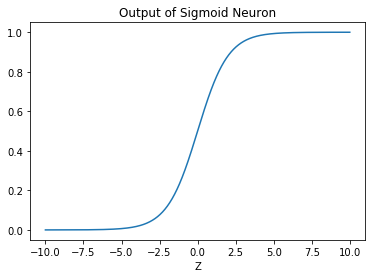

In [3]:
# The output of our sigmoid across varying inputs takes on an S shape

fig, ax = plt.subplots()

sns.lineplot(x=z, y=sigmoid_neuron_output, ax=ax)
ax.set_xlabel("Z")
ax.set_title('Output of Sigmoid Neuron');

Small changes in the weights will result in small changes in the output. We will be able to gauge the direction and magnitude of this change via partial derivatives calculated during back propagation, which we will cover below. This will allow for our neural networks.

<a id="fprop"></a>

[TOC](#toc)

# Forward Propagation

Before we get to back propogation, we have to first understand forward propagation.

Foward propogation is the process by which the input signal of our data passes through the neurons stacked in the successive layers of our network. The end result of which is a prediction in the units of the sample space of potential outcomes, which will be used to guage the accuracy of the model and update the parameters during back propogation.


In isolation, the process of forward propogation does not incorporate learning.  It simply applies a series of calculations based on fixed weighted connections between neurons.  

![dense](img/dogcat.gif)

As you can see in the above illustration, the connections between neurons can be quite dense. Every neuron extends its signal, adjusted by a weight associated by that signal, to every neuron in the successive layer. A layer where every neuron is connected to every neuron in the successive layer is called **Dense**. Some layers, such as dropout layers, inhibit some connections.

![dense_layers](img/dense_single_layer.jpeg)

[image source](http://neuralnetworksanddeeplearning.com/chap1.html)

If you were to take as an input a 28x28 pixel black and white photograph, and your network's first hidden layer is composed of 4 neurons, then there are 28 x 28 x 4 = 1024 connections already present in our network.  That's pretty dense already.

Networks are composed of an input layer and an output layer, with "hidden" layers inbetween.  

![two_hidden_layers](img/hidden_layers.jpeg)


[image source](http://neuralnetworksanddeeplearning.com/chap1.html)

[TOC](#toc)

# Building one iteration of forward propogation from scratch

Neural networks seem complicated at first, but they aren't so bad.  They perform a series of computations that we have already become familiar with throughout the course, but at a very large scale.

For forward propogation in our network, each neuron collects its inputs and sums their magnitudes adjusted by the weights, adds a bias, and translates it via the sigmoid function into an output signal between 0 and 1. 

![simplenn](img/simple_nn.jpeg)

For this notebook, we will use the built in dataset of handwritten numbers from sklearn, which comes from the UCI Machine Learning collection [digits source](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits). Each record is a 8 by 8 bit image of a handwritten number between 0 and 9. Each pixel value (a number between 0 and 16) represents the relative brightness of the pixel. 

It is similar to the famous [**MNIST**](http://yann.lecun.com/exdb/mnist/index.html) dataset which is sometimes referred to the "hello world" of computer vision [source](https://www.kaggle.com/c/digit-recognizer).  

Where as the MNIST dataset has 60,000 training examples and 10,000 test images of 28x28 pixel images of handwritten data, the data set below clocks in at just under 2000 examples of 8x8 images.

In [4]:
from sklearn.datasets import load_digits
import numpy as np

digits = load_digits()
flat_image = np.array(digits.data[0]).reshape(digits.data[0].shape[0], -1)
eight_by_eight_image = digits.images[0]


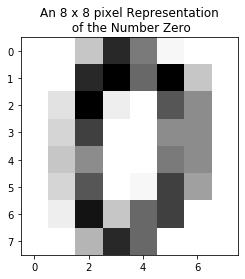

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, ax = plt.subplots()
imgplot = plt.imshow(eight_by_eight_image, cmap='Greys')
ax.set_title("An 8 x 8 pixel Representation\n of the Number Zero");

In [6]:
eight_by_eight_image

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

The large numbers in the array above indicate darker pixels, 0's indicate white pixels.

Our neural networks will require us to unrow these pixel representations. In the present cases, each column will represent 1 number with 64 rows representing a pixel position in the 8x8 square.

 $x_0 = \begin{bmatrix} 0  \\ 0 \\  \vdots \\ 0 \\4 \\\vdots \\ 0 \\ 0 \\ \vdots \end{bmatrix}$

In [10]:
# Unrow the eight_by_eight image

eight_by_eight_image.reshape(-1,1)


array([[ 0.],
       [ 0.],
       [ 5.],
       [13.],
       [ 9.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [13.],
       [15.],
       [10.],
       [15.],
       [ 5.],
       [ 0.],
       [ 0.],
       [ 3.],
       [15.],
       [ 2.],
       [ 0.],
       [11.],
       [ 8.],
       [ 0.],
       [ 0.],
       [ 4.],
       [12.],
       [ 0.],
       [ 0.],
       [ 8.],
       [ 8.],
       [ 0.],
       [ 0.],
       [ 5.],
       [ 8.],
       [ 0.],
       [ 0.],
       [ 9.],
       [ 8.],
       [ 0.],
       [ 0.],
       [ 4.],
       [11.],
       [ 0.],
       [ 1.],
       [12.],
       [ 7.],
       [ 0.],
       [ 0.],
       [ 2.],
       [14.],
       [ 5.],
       [10.],
       [12.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 6.],
       [13.],
       [10.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [9]:
# Now, align all 1797 numbers like you would books on a bookshelf.

# Sklearn stacks our images like pancakes,
# which is the form we are used to with Phase 2/3 machine learning
images = digits.data
images

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [10]:
# We can simply transpose them using .T
images.T

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 5.,  0.,  0., ...,  1.,  2., 10.],
       ...,
       [ 0., 10., 16., ...,  6., 12., 12.],
       [ 0.,  0.,  9., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

For each pixel, we need a corresponding weight, so we will initialize a weight vector with the same number of rows as columns.

Initialization of weights is a hyperparameter we will be able to tune with Keras.  One thing to keep in mind is we want to initialize our weights with small random values. [source](https://www.coursera.org/learn/neural-networks-deep-learning/lecture/XtFPI/random-initialization) If we initialize with large values, our learning may become very slow because of something called the vanishing gradient.  Think about it. If we have large weights, our activation function will tend towards 0 or 1.  If we look at the slope of our activation function near 0 and 1, it is very small. A small derivative will result in a small step of gradient descent.

In [11]:
np.random.seed(42)

# Initialize a weight vector with as many rows as pixels using small random numbers.

w_1 = np.random.uniform(-.1,.1,64).reshape(-1,1)
w_1[:10]

array([[-0.02509198],
       [ 0.09014286],
       [ 0.04639879],
       [ 0.0197317 ],
       [-0.06879627],
       [-0.0688011 ],
       [-0.08838328],
       [ 0.07323523],
       [ 0.020223  ],
       [ 0.04161452]])

Our weights align with the number of pixels

$ \hspace{1.5cm} w $  $ \hspace{1.2cm} x^{(1)} \hspace{0.4cm} x^{(2)} \hspace{1.4cm} x^{(l)} $

$w = \begin{bmatrix} -.025  \\ .090 \\  \vdots \\ .02 \\-.03 \\\vdots \\ -.088 \\ .042 \\ \vdots \end{bmatrix}$   $x $= $\begin{bmatrix} 0 & 0 & \cdots & 0\\ 0 & 0 &\cdots & 10\\  \vdots & \vdots & \ddots & \vdots \\ 5 & 0 &\cdots & 10 \\13 &12 &\cdots  &14 \\ \vdots & \vdots & \ddots & \vdots  \\ 9 & 13 & \cdots & 8 \\ 0 & 0 & \cdots & 0 \\ \vdots & \vdots & \ddots & \vdots \end{bmatrix}$

In [12]:
images.T[-5:]

array([[13., 11.,  3., ...,  9., 12., 12.],
       [10., 16., 11., ..., 13., 16., 14.],
       [ 0., 10., 16., ...,  6., 12., 12.],
       [ 0.,  0.,  9., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

The first order of business of our sigmoid neuron is to sum the products of weights and pixels.  We can do this with the dot product of our transposed w vector and our image matrix.  

In [13]:
w_1.T.dot(images.T)

array([[-1.11477398,  2.00446732,  1.57488402, ...,  1.02274619,
        -2.65746847, -1.01276836]])

Each column represents the sum of the weights and pixel intensities for each image.

We then add beta to each of these values.  Beta can be thought of as the threshold for firing.  If beta is a large negative number, the neuron will pass a large negative number to the sigmoid function, making its output essential zero.

In [14]:
# It is ok to initialize beta as 0
b_1 = 0

In [16]:
z_1 = w_1.T.dot(images.T) + b_1

We then pass the above array of results to our sigmoid function.


In [17]:
a_1 = sigmoid(z_1)
a_1

array([[0.24698194, 0.88126532, 0.82847875, ..., 0.73550718, 0.06553018,
        0.26643843]])

This is the output from a single sigmoid neuron in the first hidden layer of our network.

But of course our networks have multiple neurons per layer.  With matrix algebra, performing these calculations is not difficult.

If we follow the giph above, let's make 4 sets of weights associated with 4 neurons in a first hidden layer.

![dense](img/dogcat.gif)


$ \hspace{1cm} w_0 \hspace{1cm} w_1 \hspace{1cm} w_0 \hspace{1cm} w_1$  $ \hspace{1.2cm} x^{(1)} \hspace{0.4cm} x^{(2)} \hspace{1.4cm} x^{(l)} $

$w = \begin{bmatrix} -.25 & -.7 & .4 & -.1 \\ .90 & -.1 & -.09 & .44\\  \vdots \\ .2 &.45 & -.7 & -.08\\-.3 & -.2 & .9 & .66\\\vdots \\ -.83 & -.33 & -.43 & -.01\\ .43 & .09 & .08 & -.11\\ \vdots \end{bmatrix}$   $x $= $\begin{bmatrix} 0 & 0 & \cdots & 0\\ 0 & 0 &\cdots & 10\\  \vdots & \vdots & \ddots & \vdots \\ 5 & 0 &\cdots & 10 \\13 &12 &\cdots  &14 \\ \vdots & \vdots & \ddots & \vdots  \\ 9 & 13 & \cdots & 8 \\ 0 & 0 & \cdots & 0 \\ \vdots & \vdots & \ddots & \vdots \end{bmatrix}$

In [18]:
np.random.seed(42)
w_1 = np.random.uniform(-.1,.1, (64,4))
w_1

array([[-0.02509198,  0.09014286,  0.04639879,  0.0197317 ],
       [-0.06879627, -0.0688011 , -0.08838328,  0.07323523],
       [ 0.020223  ,  0.04161452, -0.0958831 ,  0.09398197],
       [ 0.06648853, -0.05753218, -0.06363501, -0.0633191 ],
       [-0.03915155,  0.00495129, -0.013611  , -0.04175417],
       [ 0.02237058, -0.07210123, -0.04157107, -0.02672763],
       [-0.008786  ,  0.05703519, -0.06006524,  0.00284689],
       [ 0.01848291, -0.09070992,  0.02150897, -0.06589518],
       [-0.08698968,  0.08977711,  0.09312641,  0.06167947],
       [-0.03907725, -0.08046558,  0.03684661, -0.0119695 ],
       [-0.07559235, -0.00096462, -0.0931223 ,  0.08186408],
       [-0.048244  ,  0.03250446, -0.03765778,  0.0040136 ],
       [ 0.00934206, -0.06302911,  0.09391693,  0.05502656],
       [ 0.08789979,  0.07896547,  0.01958   ,  0.08437485],
       [-0.0823015 , -0.06080343, -0.09095454, -0.03493393],
       [-0.02226454, -0.04573019,  0.0657475 , -0.02864933],
       [-0.0438131 ,  0.

In [20]:
# initialize a bias for each neuron
b_1 = np.zeros((4, 1))

z_1 = w_1.T.dot(images.T) + b_1

a_1 = sigmoid(z_1+b_1)
a_1

array([[3.59462173e-02, 9.63628877e-01, 4.77342989e-01, ...,
        2.76159105e-01, 2.46262672e-01, 7.26458363e-02],
       [3.73693562e-02, 1.59409117e-04, 9.45090648e-03, ...,
        3.81072071e-05, 2.60076382e-03, 1.01253415e-03],
       [8.72297692e-01, 9.22069900e-01, 8.73739041e-01, ...,
        8.88422698e-01, 9.89890473e-01, 8.77486074e-01],
       [9.35265146e-01, 5.08299415e-02, 6.53151747e-01, ...,
        2.79547157e-01, 9.79695284e-01, 9.03811215e-01]])

We have now 4 sigmoid neuron outputs for each example in our dataset.

Each of these neurons has a weight associated with it which adjusts its signal to pass along to the next layer.  

In our present neural network, we are attempting to identify visual patterns of numbers.

After our networks have trained sufficiently, we can think of each neuron learning to identify a portion of the pixel representation.

For example, maybe the bottom most neuron learns to identify a curved pattern on the lower quarter of our pixel grid.

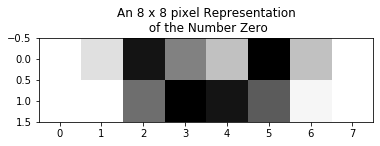

In [21]:
eight_by_eight_image = digits.images[39][6:, :]
fig, ax = plt.subplots()
imgplot = plt.imshow(eight_by_eight_image, cmap='Greys')
ax.set_title("An 8 x 8 pixel Representation\n of the Number Zero");

Then suppose the first neuron learns to identify circles in the top 1/2 of our grid

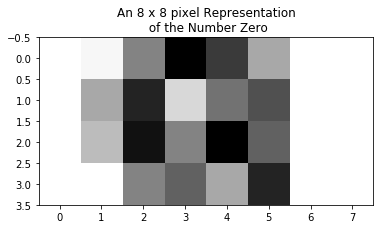

In [22]:
eight_by_eight_image = digits.images[39][0:4, :]
fig, ax = plt.subplots()
imgplot = plt.imshow(eight_by_eight_image, cmap='Greys')
ax.set_title("An 8 x 8 pixel Representation\n of the Number Zero");

[toc](#toc)

Our current network only has 1 hidden layer, but suppose we added another hidden layer.

![second_layer](img/2nd_hidden_layer.jpeg)




We can think of each successive layer of our network learning more and more complex patterns.

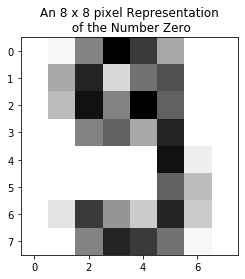

In [23]:
eight_by_eight_image = digits.images[39]
fig, ax = plt.subplots()
imgplot = plt.imshow(eight_by_eight_image, cmap='Greys')
ax.set_title("An 8 x 8 pixel Representation\n of the Number Zero");

We can imagine one node in hidden layer 1 finding a horizontal stroke representing the top half of the circle, and a node in the same layer identifying the bottom half.  Imagine a node in the next layer associating strong positive weights to these inputs. It's firing then will come to represent the upper circle as a whole. 

The deeper we go in the network, the more complex the pattern found by a neuron.  If we are separating dog images from cats, perhaps neurons in the first layer identifies curved lines hanging down in the bottom of our image.  In the next layer, the curved lines are put together with a dark circle to identify a snout with a tongue hanging from it. And so on. 

<a id='output'></a>

[toc](#toc)

# Output Layer

No matter how many hidden layers are present in our network, the output layer must track with the possible outcomes of our sample space.

For our present problem, we would like to make a prediction of a number in the range of 0 through 9.

<img src='img/soft_max.jpeg' width="300" height="300">

[source](https://www.javatpoint.com/tensorflow-mnist-dataset-in-cnn)

To do so, we use an activation function called softmax. The softmax activation function has as a neuron devoted to every possible outcome.  In our present example, the softmax has 10 neurons, 1 for each number between 0 and 9. 

Each neuron in the last hidden layer passes a signal to every neuron in the Softmax output layer, which then outputs a probability between 0 and 1 using the formula below:

$$ \large \sigma(x)_j = \frac {e^{x_j}}{\sum_k{e^{x_k}}} $$

Each neuron receives an input of weights and values $x$ that represents the probability of a number: $x_0$ represents the probability of 0 given the inputs.  The denominator normalizes the output so that the sum of all the neurons in the last layer sum to 1.  Then, the prediction of the network is simply the neuron with the highest value.

If we were to be making a binary decision, like categorizing an image as a cat or a dog, or deciding if a number was even or odd, the activation layer of our output would be a sigmoid neuron.  

Let's finish our forward propogation by outputing a prediction of even or odd.

In [23]:
y_true = (digits.target % 2 == 0).astype(int)
y_true

array([1, 0, 1, ..., 1, 0, 1])

In the above case, our positive class is associated with even numbers.

We have our hidden layer which feeds into the sigmoid output layer.

In [24]:
z_1.shape

(4, 1797)

Each of our hidden layer neurons has a weight associated with it which we will initialize with random small numbers.

In [25]:
np.random.seed(42)

w_2 = np.random.uniform(-.1,.1,(4,1))

beta_2 = 0

z_2 = w_2.T.dot(z_1)

a_2 = sigmoid(z_2 + beta_2)

y_hat = (a_2 > .5).astype(int)
y_hat.sum()

137

<a id='backprop'></a>

[toc](#toc)

# Back Propogation

![backprop](img/ff-bb.gif)

Once we have completed forward propogation, we then have to assess the accuracy of our model and adjust the weights in a way which we believe will improve our model. That process is known as back propogation.


Back prop begins with a loss function which assesses how well our predictions were. 

As you know by now, we have different loss functions associated with different types of predictions.

For continous outputs, we have become familiar with **Mean Squared Error**.  We will use MSE as our loss function if our networks model continuous outcomes.

For multiclass output like the digits, our loss function is called **categorical_crossentropy**.

For binary outcomes, we have **binary_crossentropy**.  

We have come across the latter in the loss function associated with logistic regression, under the name negative log-likelihood, and it takes the form of:

$$ \Large \mathcal{L}{(\hat{y}, y)}= -\frac{1}{m} * \sum\limits_{i=1}^m y_i\log{\hat{y}} + (1-y_i)\log(1-\hat{y}) $$

# Gradient Descent

Gradient descent is the process of calculating the partial derivatives of our loss function with regard to each tuneable parameter of our network. For our 1 layer hidden network above, we have the following parameters to tune:
    
   - 1 bias associated with the output layer
   - 4 weights attached to the 4 neurons feeding into our output layer from our hidden layer.
   - 4 biases associated with each neuron in the hidden layer.
   - 64 x 4 weights associated with each pixel's input into each of the 4 neurons in the hidden layer.

We won't look at the chain-rule calculus which goes into the parameter update calculations.

(Canvas's introduction-to-neural-networks has a good overview of the formulae peformed for each parameter update).


## Batch, minibatch, and stochastic gradient descent

There are three main flavors of gradient descent that we can implement in our networks. Each differs by the amount of data pushed through the system in one round of forward propogation. In all cases, an **epoch** refers to the end point of one cycle of data where all data points have passed through the network.  

### Batch

Batch Gradient descent is what we call pushing all our data through our network at once.  In this case, one epoch consists of only one round of forward propogation. After all of the examples have passed through the network, we initiate back-prop and update the parameters.

### Mini-Batch Gradient Descent

For mini-batch gradient descent, we randomly choose a subset of our data, push it forward through our network, calculate the loss and with gradient descent update our parameters, then proceed with a new random subset.  Each example passes once through our network during one epoch.  Once all examples have been processed, the next epoch begins.

### Stochastic Gradient Descent

Stochastic is a synonym for random.  Stochastic gradient descent picks a single example from our training set, passes it through the the network, updates the parameters, and proceedes to the next example.


There are pros and cons of each type of gradient descent (see this [blog post])(https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/). For now, we will say that using mini-batch gradient descent can substantially speed up learning. 


# Brief Note on Optimizers

In our neural networks, the actual parameter updates are regulated by optimizers. A list of available optimizers in Keras can be found here: https://keras.io/api/optimizers/

We have already been introduced to learning rate during our lectures on gradient descent. We update our parameters with small steps regulated by both the slope of the gradient w.r.t. the partial derivative and a learning rate.

$w_1 := w_1 - \delta w_1 * \alpha$

We choose $\alpha$, our learning rate, to be a small number, so that we can make incrimental steps down the gradient in the direction of minimizing our loss function.

But modern networks update the parameters in a smarter way.  Instead of treating each parameter equally, Adam, an infashion optimizer, adapts the learning rate for every parameter in order to speed up learning. 


## Different Activation Functions

So far, we have only used sigmoid activation functions in our network's hidden layers, but there are many options.  In practice, beyond its utility in the output layer to produce a binary prediction, sigmoid is usually a less preferred to what we will now be introduced to.

## tanh

**tanh**: $f(x) = tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$

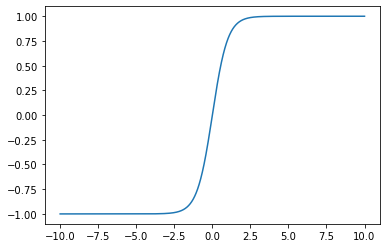

In [27]:
# Coding tanh:

X = np.linspace(-10, 10, 20000)
y_tanh = (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))

plt.plot(X, y_tanh);

tanh a shifted version of the sigmoid. The inflection point passes through 0,0 instead of 0,.5, and the output is between -1 and 1.  This means the mean of the output is centered around 0, which can make learning in the next layer easier.  tanh is almost always better in a **hidden layer** than the sigmoid because if speeds up learning [see here](https://stats.stackexchange.com/questions/330559/why-is-tanh-almost-always-better-than-sigmoid-as-an-activation-function). For the output layer, however, sigmoid makes sense for binary outcomes.  If we require an output of 0 or 1, it makes sense for the activation function to output between 0 and 1, rather than -1 and 1.

One problem with tanh (and sigmoid), is that if our input is large, then the slope of the activation function flattens out.  When conducting backpropogation, we will use the derivative of the activation function as one of our terms multiplied by a learning rate to determine how big a step to take when adjusting our weights.  If our derivative is close to zero, the step will be very small, so the speed of our learning will be very slow, which is a huge problem.  This is called the **vanishing gradient** problem.

# ReLU

ReLU, or rectified linear unit, outputs 0 for negative numbers, and the original value for positive inputs.  

**ReLU**: $f(x) = 0$ if $x\leq 0$; $f(x) = x$ otherwise 

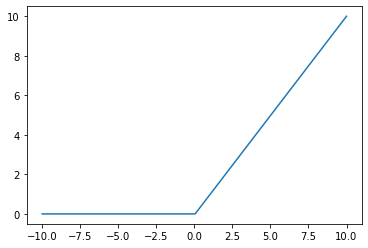

In [28]:
# Coding ReLU:

X = np.linspace(-10, 10, 200)

y_relu = list(np.zeros(100))
y_relu.extend(np.linspace(0, 10, 100))

plt.plot(X, y_relu);

ReLU is a commonly used and effective activation function because of speed.  Given that the **output** is zero when negative, some nodes become inactive (i.e. produce an output of 0).  Zero outputs take little computational power. Also, the constant gradient leads to faster learning in comparison to sigmoid and tanh, which come close to 0 with large positive and negative values.  Since the speed of our network is linked to the derivative, a derivative close to zero will result in very slow learning.